In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import bootstrap

# dataset olist_customers_dataset— таблица с уникальными   пользователей
 customer_id — позаказный идентификатор пользователя; <br>
customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта); <br>
 customer_zip_code_prefix — почтовый индекс пользователя; <br>
customer_city — город доставки пользователя; <br>
 customer_state — штат доставки пользователя; <br>

In [2]:
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-medvedeva/product_an/project/olist_customers_dataset.csv', encoding ='utf-8')

customers.head()

customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

# dataset olist_orders_dataset —  таблица заказов
order_id — уникальный идентификатор заказа (номер чека); <br>
customer_id — позаказный идентификатор пользователя; <br>
order_status — статус заказа; <br>
order_purchase_timestamp — время создания заказа; <br>
order_approved_at — время подтверждения оплаты заказа; <br>
order_delivered_carrier_date — время передачи заказа в логистическую службу; <br>
order_delivered_customer_date — время доставки заказа; <br>
order_estimated_delivery_date — обещанная дата доставки; <br>

Уникальные статусы заказов в таблице olist_orders_dataset: <br>

created — создан; <br>
approved — подтверждён; <br>
invoiced — выставлен счёт; <br>
processing — в процессе сборки заказа; <br>
shipped — отгружён со склада; <br>
delivered — доставлен пользователю; <br>
unavailable — заказ отменён по причине недоступности товара; <br>
canceled — отменён. <br>

In [3]:
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-medvedeva/product_an/project/olist_orders_dataset.csv', encoding ='utf-8')

orders.head()

orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [4]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# dataset olist_order_items_dataset - товарные позиции, входящие в заказы
 order_id — уникальный идентификатор заказа (номер чека); <br>
 order_item_id — идентификатор товара внутри одного заказа; <br>
 product_id — ид товара (аналог штрихкода); <br>
 seller_id — ид производителя товара; <br>
 shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике; <br>
 price — цена за единицу товара; <br>
 freight_value — вес товара; <br>

In [5]:
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-medvedeva/product_an/project/olist_order_items_dataset.csv', encoding ='utf-8')

items.head()

items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

### Задача 1. Оценить месячный retention в оформление заказа с помощью когортного анализа.

На первом этапе вы решили посмотреть на метрики маркетплейса и на возвращаемость клиента в продукт. <br>

Для этого вам нужно:

1) Оценить месячный retention в оформление заказа с помощью когортного анализа, так как важно, чтобы клиенты возвращались в маркетплейс для совершения больших покупок. <br>

В рамках исследования необходимо: <br>

1) Исследовать датасет и определить, какой вид заказа будет учитываться в retention <br>
2) Построить месячный retention <br>
3) Проанализировать, чему равен медианный retention 1-го месяца (т.е. взять retention 1-ого месяца для всех когорт и посчитать по этим числам медиану) <br>
4) Найти когорту с самым высоким retention на 3-й месяц. <br>
5) Проиллюстрировать результаты релевантной визуализацией, удобной для восприятия. <br>

In [6]:
## подготовка данных
orders_n = orders.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

In [7]:
# сколько заказов каждого статуса
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Здесь можно отойти  от 1/ количества заказов по статусу: delivered - это самый массовый класс заказов <br>
2/ 'delivered' - это завершенный цикл: клиент прошел весь путь и получил товар.

In [8]:
orders_n = orders_n[orders_n['order_status'] == 'delivered'].copy()

orders_n = orders_n[['customer_unique_id','order_purchase_timestamp']]
orders_n.head()

,customer_unique_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39


In [9]:
### первый заказ

orders_n["order_purchase_timestamp"] = pd.to_datetime(
    orders_n["order_purchase_timestamp"], errors='coerce'
)

orders_n["order_month"] = orders_n["order_purchase_timestamp"].dt.to_period("M")

In [10]:
# месяц первой покупки именно этого уникального пользователя
acq = (orders_n.groupby('customer_unique_id', as_index=False)['order_purchase_timestamp']
               .min()
               .rename(columns={'order_purchase_timestamp':'first_ts'}))

In [11]:
acq['cohort_month'] = acq['first_ts'].dt.to_period('M')

In [12]:
orders_1 = orders_n.merge(acq[['customer_unique_id','cohort_month']], on='customer_unique_id', how='left')

In [13]:
orders_1.head()

,customer_unique_id,order_purchase_timestamp,order_month,cohort_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02


In [14]:
orders_1['period_cohort'] = (orders_1['order_month'] - orders_1['cohort_month']).apply(lambda x: x.n)

In [15]:
### retention
cohort = (orders_1.groupby(['cohort_month','period_cohort'])['customer_unique_id']
                 .nunique()
                 .reset_index(name='active_users'))

In [16]:
cohort_sizes = (orders_1.drop_duplicates(['customer_unique_id','cohort_month'])
                         .groupby('cohort_month')['customer_unique_id']
                         .nunique()
                         .rename('cohort_size')
                         .reset_index())

In [17]:
cohort_df = cohort.merge(cohort_sizes, on='cohort_month', how='left')

cohort_df['retention'] = cohort_df['active_users'] / cohort_df['cohort_size']

retention = cohort_df.pivot(index='cohort_month', columns='period_cohort', values='retention')

retention.index = retention.index.astype(str).str.slice(0, 7)

retention.columns = retention.columns.astype(int)

retention

period_cohort,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.007634
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,NaN,0.004184,0.001395,0.006974,0.004184,0.001395,0.001395,0.002789,0.004184,0.001395,NaN
2017-02,1.0,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,0.003071,0.001229,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN
2017-03,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,0.003596,0.001199,0.001998,0.001199,0.001598,0.002397,0.000799,0.001199,NaN,NaN
2017-04,1.0,0.006206,0.002216,0.001773,0.002660,0.002660,0.003546,0.003103,0.003103,0.001773,0.002660,0.000887,0.000443,0.000443,0.000887,0.000887,0.001330,NaN,NaN,NaN
2017-05,1.0,0.004636,0.004636,0.002898,0.002898,0.003187,0.004057,0.001449,0.002608,0.002608,0.002608,0.003477,0.002318,0.000290,0.001739,0.002028,NaN,NaN,NaN,NaN
2017-06,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,0.002305,0.001317,0.001976,0.002963,0.003622,0.001646,0.001646,0.002305,NaN,NaN,NaN,NaN,NaN


In [18]:
### Метрики 

# --- Маска для маленьких когорт (например < 50 пользователей) ---
small_str = cohort_sizes.copy()
small_str['cohort_month'] = small_str['cohort_month'].astype(str).str.slice(0, 7)
small_str = (small_str
             .set_index('cohort_month')['cohort_size']
             .lt(50))
mask = small_str.reindex(retention.index).fillna(False).to_numpy()

In [19]:
retention_plot = retention.copy()
retention_plot.loc[mask, :] = np.nan  # скрываем маленькие когорты

In [20]:
median_ret_1m = retention[1].median() if 1 in retention.columns else np.nan
best_cohort_3m = retention[3].idxmax() if 3 in retention.columns else None
best_value_3m = retention[3].max() if 3 in retention.columns else np.nan

In [21]:
print(f"Медианный retention на 1-й месяц: {median_ret_1m:.2%}")
print(f"Лучшая когорта на 3-й месяц: {best_cohort_3m}, retention = {best_value_3m:.2%}")

Медианный retention на 1-й месяц: 0.51%
Лучшая когорта на 3-й месяц: 2017-06, retention = 0.43%


<module 'matplotlib.pyplot' from '/opt/tljh/user/lib/python3.7/site-packages/matplotlib/pyplot.py'>

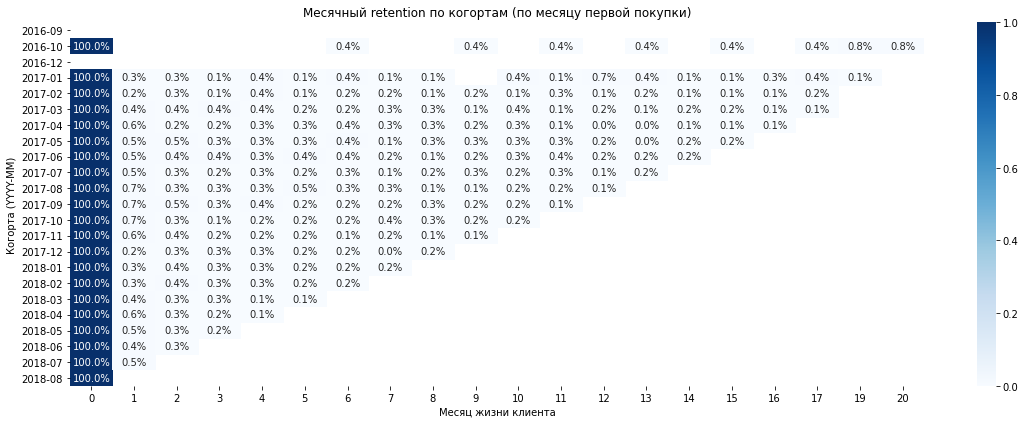

In [22]:
#Визуализация
plt.figure(figsize=(16,6))
sns.heatmap(retention_plot, annot=True, fmt=".1%", cmap="Blues",
            vmin=0, vmax=np.nanquantile(retention.values, 0.95))
plt.title("Месячный retention по когортам (по месяцу первой покупки)")
plt.ylabel("Когорта (YYYY-MM)")
plt.xlabel("Месяц жизни клиента")
plt.tight_layout()
plt

In [23]:
### самопроверка

orders_1.groupby('customer_unique_id')['order_purchase_timestamp'].count().value_counts()

1     90557
2      2573
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: order_purchase_timestamp, dtype: int64

# Нынешние инсайты:
1) Retention: уже через месяц возращается около 0,5 % клиентов. То есть 99,5% исчезают после первой покупки.. <br>
90557 - сделали один заказ <br>
2573 - сделали два заказа (2,8 % процента от первого заказа) <br>
181 - сделали три заказа <br>
2) Лучшая когорта - июнь 2017. Слабая и retention на 3 месяц всего 0,4% <br>

### Задача 2. Определить, существует ли product/market fit у маркетплейса.

Построив retention, вы решили оценить, насколько хорошо продукт закрывает потребности клиента. <br>

Для этого вам нужно:<br>

1) Определить, существует ли product/market fit у этого маркетплейса. Ведь до сих пор непонятно, можно ли масштабировать подобный продукт на новые рынки. Есть вероятность, что маркетплейс будет приносить убытки. <br>

В рамках исследования необходимо: <br>

1) Оценить наличие product/market fit у данного продукта с помощью когортного анализа, полученного на предыдущем шаге.<br>
2) Пояснить свою позицию и сформулировать, на чём маркетплейс должен сконцентрироваться в ближайшее время. Если PMF есть, то в какую сторону лучше развивать продукт дальше? Если PMF нет, то какие причины могут быть у этого? <br>
3) Подкрепить свои выводы релевантной визуализацией, удобной для восприятия.<br>

## 1. Product/market fit у маркетплейса нет.
Retention очень низкий: почти все клиенты совершают только один заказ , и лишь 2,8 % процента возвращаются на второй месяц. Для реального PMF нужно, чтобы клиенты стабильно возвращались и продукт закрывал их потребности. Здесь такого не наблюдается.

In [24]:
# Доля клиентов с >=2 заказами (минимальная проверка PMF)
tmp_counts = (orders_n.groupby('customer_unique_id')['order_purchase_timestamp']
                    .count()
                    .rename('orders_cnt'))
repeat_rate = (tmp_counts >= 2).mean()
print(f"Доля клиентов с >=2 заказами: {repeat_rate:.1%}")

Доля клиентов с >=2 заказами: 3.0%


Дополнительно рассчитана доля пользователей, совершивших как минимум две покупки. Она составила всего 3%, что подтверждает отсутствие повторного поведения и ценности продукта.

Product/Market Fit отсутствует <br>
Уже через первый месяц остаётся ~0,5% клиентов (retention ≈ 0.5%) <br>
Только 3% клиентов совершают повторный заказ <br>
По когортам возвраты практически обнулены уже на 2–3 месяце <br>
Лучшая когорта (июнь 2017) показала retention всего 0,4% на 3-й месяц <br>
Заключение: Пользователи не возвращаются, продукт не формирует устойчивую ценность → PMF нет. <br>

## 2. Что делать дальше. <br>
1) PMF нет - ретеншен показывает это. Масштабироватьь такой продукт рано, потому что LTV не закрывает расходы на привлечение. => Главный приоритет - придумать , как мотивировать людей делатьповторные покупки , чтобы рос LTV. <br>
2) Онбординг. Если процесс 'регистрация -> корзина -> оплата" сложный, то не завершит заказ или клиент не вернется. Нужно упростить весь процесс , убрать лишие шаги и ошибки.  <br>
3) Ассортимент. Люди приходят на маркетплейс ради разнообразия товаров. Если нет категорий или товаров, которые люди покупают регулярно, клиент не видит смысл продалжать совершать покупки. Нужно рассмотреть категории товаров, которые ведут за собой более количество возвратов и расширить линейку.  <br>
3) Доставка и сервис. Если клиенты устраивает ассортимент, он не вернется после плохой доставки. Дорогая ( даже платная), долгая, без трекинга - эти действия урещают количество повторных заказов. Нужно, чтобы доставка была сталбильной, быстрой и без сюрпризов. <br>
### Почему такое происходит? <br>
1) Клиенты не видят ценности , чтобы возвращаться снова.<br> 
2) Возможно продукт решает разовую задачи , тем самым не формулирует привычку на покупку и регулярную потребность.<br>

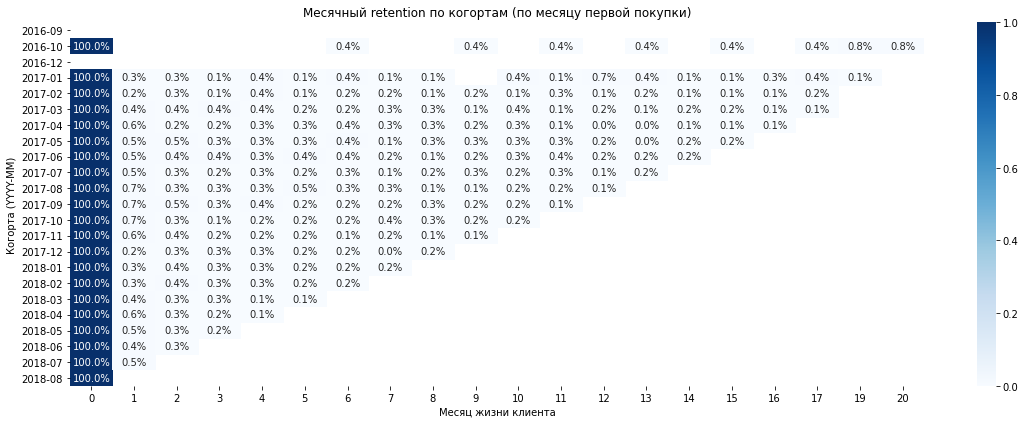

In [25]:
plt.figure(figsize=(16,6))
sns.heatmap(retention_plot, annot=True, fmt=".1%", cmap="Blues",
            vmin=0, vmax=np.nanquantile(retention.values, 0.95))
plt.title("Месячный retention по когортам (по месяцу первой покупки)")
plt.ylabel("Когорта (YYYY-MM)")
plt.xlabel("Месяц жизни клиента")
plt.tight_layout()
plt.show()

### Задача 3. Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

1) Вы разобрались с наличием product/market fit. Теперь вас просят сформулировать продуктовые метрики маркетплейса, чтобы компания могла на них ориентироваться. <br>

В первую очередь необходимо: <br>

Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании. <br>

Первая метрика должна отражать рост объёма продаж маркетплейса. <br>
Вторая — показывать объем аудитории, которой продукт доставляет ценность.<br>
Третья — отражать заинтересованность новых клиентов в продукте (даже если вы не можете посчитать ее на имеющихся у вас данных).<br><br>
Четвёртая — отражать вовлеченность клиента в продолжение использования продукта.<br>
Пятая — отражать денежное выражение вовлеченности клиента.<br>
Визуализируйте первую, вторую, четвёртую и пятую метрики. Используйте месячную гранулярность и окно в 1 месяц, если это нужно.<br>

In [28]:
### Первая матрика - рост объема продаж маркетплейса. 
### GMV (Gross Merchandise Value) - показывает рост бизнеса и напрямую отрадает выручку.

items['price'] = pd.to_numeric(items['price'], errors='coerce')
 
items['freight_value'] = pd.to_numeric(items['freight_value'], errors='coerce')

items['gmv'] = items['price'] + items['freight_value']

orders_new = orders[orders["order_status"] == "delivered"].copy()
orders_new['order_purchase_timestamp'] = pd.to_datetime(orders_new['order_purchase_timestamp'], errors='coerce')

orders_new["order_month"] = orders_n["order_purchase_timestamp"].dt.to_period("M")

gmw_orders = orders_new.merge(items, on='order_id', how='left')

gmw_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,gmv
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,28.62


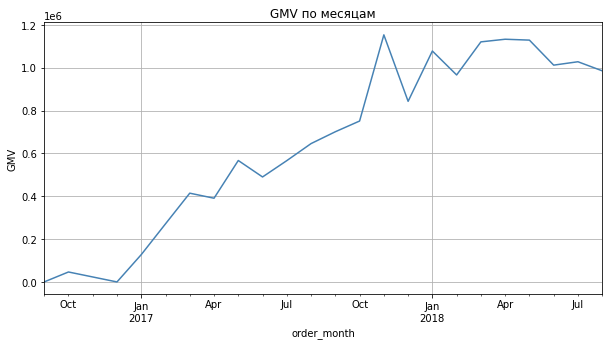

In [29]:
#  гранулярность и окно в 1 месяц
monthly_gmv = gmw_orders.groupby('order_month')['gmv'].sum().rename('GMV')

monthly_gmv

plt.figure(figsize=(10, 5))
monthly_gmv.plot(title="GMV по месяцам", color="steelblue")
plt.ylabel("GMV")
plt.grid(True)
plt.show()

Уникальные клиенты:
 order_month
2016-09       1
2016-10     262
2016-12       1
2017-01     718
2017-02    1630
2017-03    2508
2017-04    2274
2017-05    3479
2017-06    3076
2017-07    3802
2017-08    4114
2017-09    4083
2017-10    4417
2017-11    7183
2017-12    5450
2018-01    6974
2018-02    6400
2018-03    6914
2018-04    6744
2018-05    6693
2018-06    6061
2018-07    6100
2018-08    6310
Freq: M, Name: PayingUsers, dtype: int64


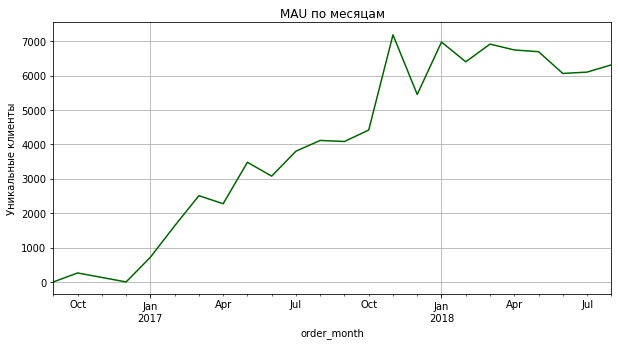

In [34]:
### Вторая метрика - объем аудитории, которой продукт доставляет ценность.
### MAU (Monthly Active Users) - сколько уникальных клиентов реально пользуются продуктом.

orders_2 = gmw_orders.merge(customers[['customer_id','customer_unique_id']], on='customer_id', how='left')

mau = orders_2.groupby('order_month')['customer_unique_id'].nunique().rename('PayingUsers')

print(f"Уникальные клиенты:\n", mau)

plt.figure(figsize=(10, 5))
mau.plot(title="MAU по месяцам", color="darkgreen")
plt.ylabel("Уникальные клиенты")
plt.grid(True)
plt.show()

In [31]:
### Третья метрика - заинтересованность новых клиентов в продукте.
### Conversion rate - идикатор интереса и силы первого опыта.

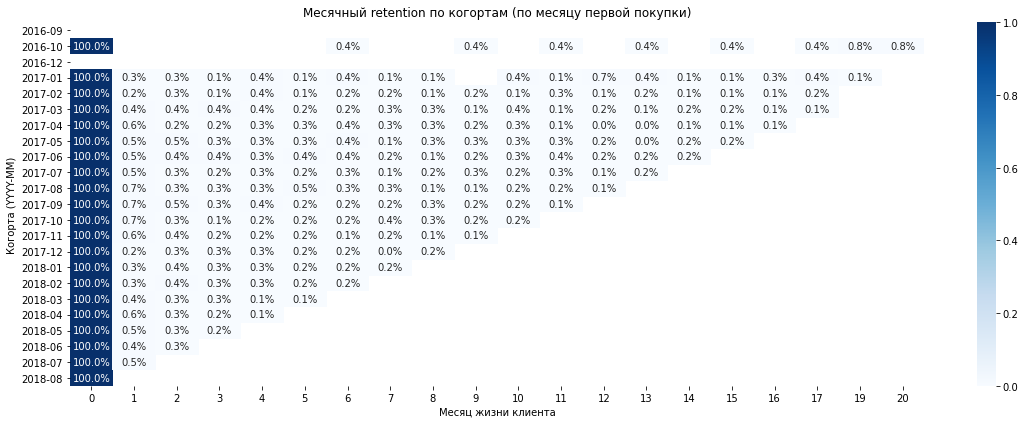

In [35]:
### Четвертая метрика -  вовлеченность клиента в продолжение использования продукта.
### Retention (повторные заказы)

retention

plt.figure(figsize=(16,6))
sns.heatmap(retention_plot, annot=True, fmt=".1%", cmap="Blues",
            vmin=0, vmax=np.nanquantile(retention.values, 0.95))
plt.title("Месячный retention по когортам (по месяцу первой покупки)")
plt.ylabel("Когорта (YYYY-MM)")
plt.xlabel("Месяц жизни клиента")
plt.tight_layout()
plt.show()

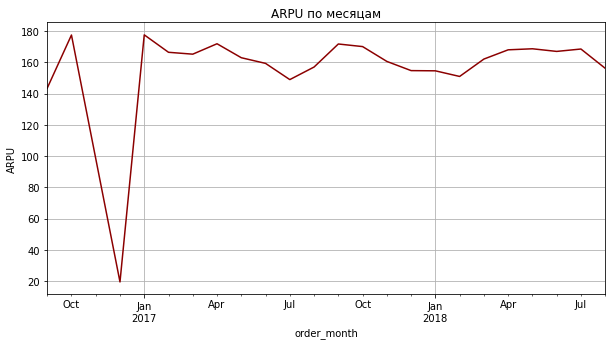

In [37]:
### Пятая метрика - денежное выражение вовлеченности клиента
### 1) ARPPU (средний дозод на пользователя); <br>


arppu = (monthly_gmv / mau).rename('ARPPU')

arppu.head(10)

plt.figure(figsize=(10, 5))
arppu.plot(title="ARPU по месяцам", color="darkred")
plt.ylabel("ARPU")
plt.grid(True)
plt.show()

# Нынешние инсайты:
1) GMV: рост в 2017 почти до 1 млн. В 2018 - стабилизация и GMV держится на уровне 0,8-1,1 млн. <br>
Вывод: продукт быстро вырос и ушел в плато. <br>
2) MAU:повторяет динамику GMV.количество уникальных активных клиентов стабилизировалось на уровне 6–7 тыс. в месяц. <br>
Вывод: стагнация GMV связана не с падением ср чека, а с малоактивной клиентской базой.<br>
3) ARPPU: В самом начале есть просадка почти до нуля. Мало пользователей = мало заказов.<br>
Вывод: пользователи, которые остаются, тратят примерно одинаково. Проблема не в чеке, а в том, что новых активных клиентов становится мало. <br>

### Задача 4. Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

Посмотрев с продактом на когортный анализ и метрики, вы решили, что нужно изменить продукт. Метрики необходимо срочно повышать. Вместе с командой вы сформулировали 3 гипотезы, в которые вы верите. По каждой гипотезе команда заполнила показатели по Ease, Confidence. Вам нужно заполнить самый важный показатель — Impact. Для этого вам требуется:

Выбрать одну из трёх основных гипотез с помощью фреймворка ICE, которые были сформированы продактом и, кажется, должны улучшить пользовательский опыт в маркетплейсе.

1) Для расчёта Impact возьмите данные с июня 2017 года. Считайте, что конверсия в повторный заказ равна величине медианного retention 1-го месяца (см. пункт 1 проекта) <br>

In [43]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [44]:
median_ret_1m = float(retention[1].median()) if 1 in retention.columns else 0.0

In [45]:
## подготовка данных
orders_3 = orders.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

orders_3['order_purchase_timestamp'] = pd.to_datetime(orders_3['order_purchase_timestamp'], errors='coerce')

In [46]:
### данные с июня 2017 года. 
june_orders = orders_3[orders_3['order_purchase_timestamp'] >= '2017-06-01'].copy()

june_orders.head()

unique_clients_june = june_orders['customer_unique_id'].nunique()

print("Уникальные клиенты с июня 2017 :", unique_clients_june)

Уникальные клиенты с июня 2017 : 85019


In [47]:
# Простой базовый перевод в "базовые доп. заказы" через медианный ретеншн:
base_extra_orders = int(unique_clients_june * median_ret_1m)

In [48]:
#  гипотезы
hypotheses = [
    {
        'name': 'Исправить баг процессинга (все новые клиенты)',
        'segment_size': 85019,   # твои числа из расчётов
        'uplift': 0.08,          # 8% доп. заказов в сегменте
        'confidence': 8,         # как на скрине
        'effort': 6,             # как на скрине (Ease)
    },
    {
        'name': 'Сократить ETA в топ-5 категориях',
        'segment_size': 29756,
        'uplift': 0.04,          # 4%
        'confidence': 10,        # как на скрине
        'effort': 4,             # как на скрине
    },
    {
        'name': 'Email-подборки для одноразовых покупателей',
        'segment_size': 42509,
        'uplift': 0.05,          # 5%
        'confidence': 5,         # как на скрине
        'effort': 9,             # как на скрине
    },
]


def impact_bucket(x):
    # шкала из твоей таблицы (значение метрики = кол-во новых заказов)
    if x <= 50: return 1
    elif x <= 150: return 2
    elif x <= 350: return 3
    elif x <= 750: return 4
    elif x <= 1550: return 5
    elif x <= 3150: return 6
    elif x <= 6350: return 7
    elif x <= 12750: return 8
    elif x <= 25550: return 9
    else: return 10

rows = []
for h in hypotheses:
    # количество новых заказов от гипотезы
    impact_orders = int(h['segment_size'] * h['uplift'])   # ВНИМАНИЕ: без умножения на median_ret_1m
    impact = impact_bucket(impact_orders)

    ice = (impact * h['confidence']) / max(h['effort'], 1e-6)
    rows.append({**h,
                 'impact_orders': impact_orders,
                 'impact_score': impact,
                 'ICE': ice})

ice_df = pd.DataFrame(rows).sort_values('ICE', ascending=False)
ice_df[['name','segment_size','uplift','impact_orders','impact_score','confidence','effort','ICE']]

,name,segment_size,uplift,impact_orders,impact_score,confidence,effort,ICE
1,Сократить ETA в топ-5 категориях,29756,0.04,1190,5,10,4,12.500000
0,Исправить баг процессинга (все новые клиенты),85019,0.08,6801,8,8,6,10.666667
2,Email-подборки для одноразовых покупателей,42509,0.05,2125,6,5,9,3.333333


На первом месте — гипотеза про сокращение ETA в топ-5 категориях (ICE=12.5): быстро реализуемая и максимально надежная. <br>

На втором месте — исправление бага процессинга (ICE=10.7): большой эффект, но выше трудоемкость. <br>

На третьем месте — email-подборки (ICE=3.3): низкий приоритет из-за высокой сложности. <br>

Вывод:<br> 
Выбираем Гипотезу 1 "Если сократим ETA (срок доставки) в топ-5 категорий, то клиенты перестанут получать свои заказы с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных покупок.".<br>

## Задача 5. Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

После предыдущего исследования у вас появилась гипотеза, которую можно реализовать для значительного улучшения метрик компании. Вы предложили использовать A/B-тестирование для проверки её эффективности.

Продакт попросил вас:

1) Сформулировать метрики, на которые должна повлиять выбранная вами гипотеза.
2) Сформулировать хотя бы по одной метрике в категории: целевые, прокси, guardrail и объяснить свой выбор.

### Первая матрика - рост объема продаж маркетплейса. 
GMV (Gross Merchandise Value) - показывает рост бизнеса и напрямую отрадает выручку
Причина: это денежный эффект от улучшения доставка: меньше отмен, больше завершенных заказов, выше оборот.

### Целевая метрика ( ради чего бы делаем гипотезу)

Метркиа: доля клиентов, сделавших повторный заказ. <br>
Причина: если сократить ETA, клиентский опыт улучшится, и они будут чаще возвращаться.. <br>

### Прокси метрика ( косвенная метрика = сигнал , что гипотеза работает)
Метрика: доля доставленных заказов в топ-5 категорий с сокращённым ETA. <br>
Причина: доля доставленных заказов быстро реагирует на улучшение ETA.
Это «ранний сигнал», что гипотеза двигает метрику в нужную сторону.

### Guardrail - метрика ( защитная , чтобы не испортить продукт)
Метрика: конверсия в заказ (CR)
(оформленные заказы / потенциальные покупатели). <br>
Почему: если дать нагрузку на логистику или изменить процесс доставки, это может повлиять на конверсию — куратор об этом прямо говорил

# ИТОГОВЫЙ ОТЧЕТ <br>

## Проблема продукта <br>

Было замечено, что рост выручки маркетплейса остановился: продажи держатся на одном уровне, хотя раньше они активно росли (GMV перестал расти). <br>
Анализ показал, что клиенты делают заказ один раз и редко возвращаются. <br>
Медианный retention первого месяца - 0,5%. <br>
Доля клиентов с ≥2 заказами - 3%. <br>
Лучшая когорта (июнь 2017) показала retention на 3-й месяц всего 0,4%. <br>
Средний чек (ARPPU) у оставшихся пользователей стабилен, значит проблема не в их платежеспособности, а в том, что продукт не удерживает клиентов. Когортный анализ подтвердил крайне низкий уровень возврата в первый месяц после покупки. <br>

## Общие выводы по результатам анализа

База активных клиентов перестала расти: в 2018 MAU стабилизировался на уровне ~6-7 тыс. <br>
ARPPU держится на уровне ~150–180 у.е., значит проблема не в доходности, а в возвращаемости. <br>
Удержание крайне низкое: медианный retention 1-го месяца - 0,5%, повторные заказы делают только 3% клиентов. <br>
По ICE-модели приоритет получила гипотеза о сокращении ETA в топ-5 категорий как наиболее перспективная для роста повторных заказов. <br>

## Рекомендации

Протестировать сокращение ETA в топ-5 категорий, чтобы повысить долю повторных заказов. <br>
Сфокусироваться на удержании: ускорение доставки и программы лояльности для роста MAU и retention.<br>
Все изменения проверять через A/B-тесты, отслеживая целевые и guardrail-метрики (повторные заказы, доля доставленных заказов, конверсия). <br>


    